In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import dateutil.parser
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [43]:
fp = os.path.join('data', 'fantasy_10000.json.gz')
data = pd.read_json(fp, lines=True)

In [44]:
rating = data['rating']
data['review_text'] = data['review_text'].apply(len)

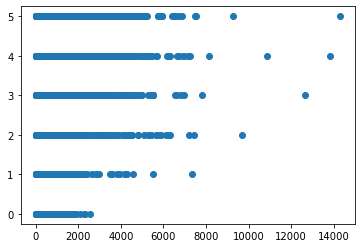

In [45]:
#Question 1
plt.scatter(data['review_text'], rating)

In [46]:
#Question2
predictor = scipy.stats.linregress(data['review_text'], rating)
#theta1
predictor.slope

6.873716748962768e-05

In [47]:
#theta0
predictor.intercept

3.685681355016952

In [48]:
predictions = (predictor.slope*data['review_text'])+predictor.intercept
mse2 = np.square(np.subtract(data['rating'], predictions)).mean()
#MSE
mse2

1.5522086622355349

In [49]:
#Question3
data['weekday'] = data['date_added'].apply(lambda x: dateutil.parser.parse(x).weekday())
data['year'] = data['date_added'].apply(lambda x: dateutil.parser.parse(x).year)

In [50]:
ohe = OneHotEncoder(drop='first')

In [51]:
ohe.fit(data[['weekday','year']])

OneHotEncoder(drop='first')

In [52]:
#Q3 answer
X = ohe.transform(data[['weekday','year']]).toarray()
X[:2]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.]])

In [53]:
#Question4
reg = LinearRegression()
reg.fit(data[['review_text','weekday','year']], data['rating'])
reg.coef_

array([5.50923292e-05, 8.75072300e-03, 5.23592268e-02])

In [54]:
reg.intercept_

-101.7424610652963

In [55]:
x_pred = reg.predict(data[['review_text','weekday','year']])

In [56]:
mse41 = np.square(np.subtract(data['rating'],x_pred)).mean()
#MSE for weekday and year as direct features
mse41

1.536774049870521

In [57]:
data['length'] = data['review_text']

In [58]:
ct = ColumnTransformer([('ohe', OneHotEncoder(drop = 'first'), ['weekday', 'year'])])
pl = Pipeline([('ct', ct), ('lr', LinearRegression())])
pl.fit(data[['weekday', 'year', 'length']], data['rating'])

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['weekday', 'year'])])),
                ('lr', LinearRegression())])

In [59]:
mse42 = np.square(np.subtract(data['rating'], pl.predict(data[['weekday','year','length']]))).mean()
#MSE for one hot encoding
mse42

1.5150910945986422

In [60]:
#Queston 5
dat = data[['rating', 'weekday','year','review_text']]
X = dat.drop('rating', axis =1)
y = dat['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.5)

In [61]:
reg = LinearRegression()
reg.fit(X_train, Y_train)
#MSE for model 1 for test 
print(np.square(np.subtract(Y_test, reg.predict(X_test))).mean())
#MSE for model 1 for train
print(np.square(np.subtract(Y_train, reg.predict(X_train))).mean())

1.536625462828211
1.5372231098132425


In [62]:
ct = ColumnTransformer([('ohe', OneHotEncoder(drop = 'first'), ['weekday', 'year'])])
pl = Pipeline([('ct', ct), ('lr', LinearRegression())])
pl.fit(X_train, Y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['weekday', 'year'])])),
                ('lr', LinearRegression())])

In [63]:
#MSE for one hot encoding for test 
print(np.square(np.subtract(Y_test, pl.predict(X_test))).mean())
#MSE for one hot encoding for train
print(np.square(np.subtract(Y_train, pl.predict(X_train))).mean())

1.5211678756107652
1.5136878483235623


In [64]:
fp = os.path.join('data', 'beer_50000.json')
def parseData(fp):
    for i in open(fp):
        yield eval(i)
data = list(parseData(fp))

In [65]:
beer = pd.DataFrame(data)

In [66]:
reviews = np.array(beer['review/overall'] >= 4)

In [67]:
#Question 7
beer['length'] = beer['review/text'].apply(len)
reg = LogisticRegression(class_weight = 'balanced')
X = beer['length'].to_numpy().reshape(-1, 1)
Y = np.array(beer['review/overall'] >= 4)
reg.fit(X,Y)

LogisticRegression(class_weight='balanced')

In [68]:
preds = pd.DataFrame(reg.predict(X))
beer['predictions'] = preds
beer['accurate'] = beer['review/overall'] >= 4
comparison = beer[['predictions','accurate']]
comparison

,predictions,accurate
0,False,False
1,False,False
2,False,False
3,False,False
4,True,True
...,...,...
49995,False,True
49996,True,True
49997,False,False
49998,True,True


In [69]:
#TP 
TP = comparison[comparison['predictions'] == True]
TP = TP['predictions'] == TP['accurate']
TP = TP.value_counts()[1]/beer.shape[0]
#TN 
TN = comparison[comparison['predictions'] == False]
TN = TN['predictions'] == TN['accurate']
TN = TN.value_counts()[1]/beer.shape[0]
#FP
FP = comparison[comparison['predictions'] == True]
FP = FP['predictions'] != FP['accurate']
FP = FP.value_counts()[1]/beer.shape[0]
#FN
FN = comparison[comparison['predictions'] == False]
FN = FN['predictions'] != FN['accurate']
FN = FN.value_counts()[1]/beer.shape[0]

In [70]:
TP, TN, FP, FN

(0.28402, 0.21006, 0.1177, 0.38822)

In [71]:
#True Negative Rate 
TNR = TN/(TN+FP)
# True Positive Rate
TPR = TP/(TP+FN)

TPR, TNR

(0.4224979174104487, 0.6408957773980961)

In [72]:
#balanced error rate
BER = 1 - 0.5*(TPR+TNR)
BER

0.46830315259572763

In [92]:
beer['pos'] = reg.decision_function(X)
sorted_pos = beer.sort_values(by = 'pos', ascending = False)

In [76]:
#Question 8

def TP_rates(beer, size):
    TP = beer[beer['predictions'] == True]
    TP = TP[TP['accurate'] == True].shape[0]/size
    return TP

In [77]:
TP_rate = []
for i in range(1, 10001):
    TP_rate.append(TP_rates(sorted_pos.iloc[0:i], i))

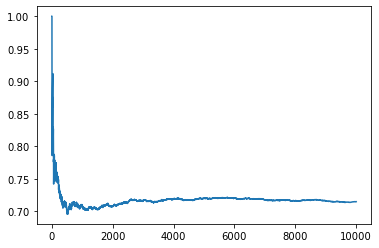

In [78]:
plt.plot(TP_rate)

In [91]:
#Question 9
beer['pos & neg'] = abs(beer['pos'] - 0.5)
sort = beer.sort_values(by = 'pos & neg', ascending = False)

In [87]:
def accuracy(sort, k):
    rows = sort.iloc[0:k]
    return np.average(rows['predictions'] == rows['accurate'])

In [88]:
TP_confident_scores = []
for i in [1,100,10000]:
    TP_confident_scores.append(accuracy(sort, i))

TP_confident_scores

[1.0, 0.42, 0.3912]

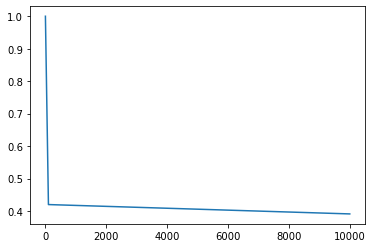

In [90]:
plt.plot([1,100,10000], TP_confident_scores)